# Méthodes des différences temporelles - SARSA et Q-Learning

*Version 1 - Elise Chin, December 2021*

- SARSA : TD on-policy control (estimate $q_{\pi}(s,a)$ by running the policy $\pi$)
- Q-Learning : TD off-policy control (estimate $q_*(s,a)$ while running a policy with more exploration)

1. [Frozen Lake](#sec1)
2. [SARSA](#sec2)
3. [Q-learning](#sec3)
4. [Comparaison](#sec4)
5. [Cart-pole en tabulaire](#sec5)

## <a name="sec1">1. Frozen Lake</a>

L'environnement Frozen Lake est un monde grille incertain dans lequel on part depuis un état initial (la case la plus en haut à gauche) pour aller à un état final (la case la plus basse à droite). L'environnement est incertain car vous marchez sur un lac gelé et l'épaisseur de glace varie. Vous pouvez donc tomber dans l'eau dans certaines cases. De plus, la glace est plus glissante à certains endroits, et donc faire un pas peut vous mener plus loin que prévu... et si le vent s'en mèle...

__Actions :__
- LEFT = 0
- DOWN = 1
- RIGHT = 2
- UP = 3

__Récompense__
L'épisode se termine lorsqu'on atteint l'objectif ou que l'on tombe dans un trou. On reçoit une récompense de +1 si l'objectif est atteint, 0 sinon.


Au lieu d'essayer d'estimer le modèle de transition, on va utiliser SARSA et Q-learning pour résoudre ce problème.

Utilisez l'environnement Frozen Lake pour implémenter SARSA et Q-learning. Utilisez d'abord l'environnement avec une grille 4x4 pour tester vos algorithmes, puis vous devriez pouvoir les utiliser pour la grille 16x16.

### FrozenLake - familiarisation avec l'environnement

Evaluez une politique aléatoire. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gym
from tqdm import tqdm

In [4]:
#env = gym.make("FrozenLake8x8-v1", is_slippery=True)
env = gym.make("FrozenLake8x8-v0", is_slippery=True)
num_states = env.observation_space.n
num_actions = env.action_space.n
print("Environnement avec", num_states, "états et", num_actions, "actions")

env.reset()
nbIt = 0
rew = []
done = False
while not done:
    observation, reward, done, info = env.step(np.random.randint(4))
    env.render()
    nbIt += 1
    rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues :",rew)
env.close()

Environnement avec 64 états et 4 actions
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF


## <a name="sec2">2. SARSA</a>

### 2.1 Implémentation

#### $\epsilon$-greedy

Implémentez une fonction qui choisit une action avec la stratégie $\epsilon$-greedy :
* exploite avec un probabilité $1-\epsilon$ : ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$ : on choisit une action de manière uniforme sur toute les actions.

In [24]:
def eps_greedy(q, s, epsilon, num_actions=num_actions):
    
    p = np.random.rand()
    if p > epsilon:
        list_q = np.argwhere(q[s] == np.amax(q[s])).flatten().tolist()
        action = np.random.choice(list_q)
    else: 
        action = np.random.choice(num_actions) 
    
    return action

#### SARSA

Implémentez un fonction SARSA qui prend en paramètre :
 * $num\_episodes$ le nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. 

Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug :
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$

In [42]:
def SARSA(env, num_episodes, gamma=1, alpha=0.02, epsilon=0.2, verbose=False):
    
    # Initialization
    q = np.zeros((env.observation_space.n, env.action_space.n))
    episodes_reward = [] # Final reward per episode (0 or 1)
    
    # Starting the SARSA learning
    for i_episode in tqdm(range(num_episodes)):
        
        state = env.reset()
        action = eps_greedy(q, state, epsilon)
        
        done = False
        while not done:
            
            # Execute action, observe the reward and get the next state
            next_state, reward, done, _ = env.step(action)
            
            # Learning the Q-value
            if done: # new_state is terminal
                q[state, action] = q[state, action] + alpha * (reward - q[state, action])
                episodes_reward.append(reward)
                break
            else:
                next_action = eps_greedy(q, next_state, epsilon)
                q[state, action] = q[state, action] + alpha * (reward + gamma*q[next_state, next_action] - q[state, action])
                state = next_state
                action = next_action
            
    return q, episodes_reward

#### Exploitation

On implémente la fonction `exploitation()` qui permet d'exploiter la politique $\pi$ donnée. Elle renvoie la liste des récompenses par épisode et la récompense moyenne sur l'ensemble des épisodes. La fonction `exploit_and_plot()` appelle la méthode précédente et affiche les récompenses lissées sur une fenêtre de `window_size` épisodes grâce à `running_avg()`.

In [38]:
def exploitation(env, q, num_episodes):
    
    # Initialization
    episodes_reward = []
    
    # For every episode...
    for i_episode in tqdm(range(num_episodes)):

        state = env.reset()
        action = np.argmax(q[state])
 
        done = False
        while not done:
            state, reward, done, _ = env.step(action)
            action = np.argmax(q[state])

        episodes_reward.append(reward)
        
    return episodes_reward, np.mean(episodes_reward)

def running_avg(data, window_size):
    res = np.zeros(len(data)-window_size)
    sum=0
    for i in range(window_size):
        sum += data[i]
    for i in range(len(data)-window_size):
        res[i]= sum/window_size
        sum -= data[i]
        sum += data[i+window_size]
    return res

def exploit_and_plot(env, q, num_episodes, window_size):
    rewards, rewards_mean = exploitation(env, q, num_episodes)
    plt.plot(running_avg(rewards, window_size))
    print(f'Mean = {rewards_mean}')
    return rewards, rewards_mean

Vous trouverez ci-dessous une fonction `plotQ()` qui génère une représentation de la table $Q$ : pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 

In [9]:
def plotQ(q_table, map_size):
    """Visualisation de la table Q pour FrozenLake 4x4 et 8x8.
    Passez la taille (4 ou 8) en paramètres
    """
    
    if(map_size == 4):
        MAP = [
            "SFFF",
            "FHFH",
            "FFFF",
            "HFFG"
        ]
    else:
        MAP=[
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ]
    best_value = np.max(q_table, axis=1).reshape((map_size, map_size))
    best_policy = np.argmax(q_table, axis=1).reshape((map_size, map_size))
    
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show() 

### 2.2 FrozenLake 4x4

In [43]:
env4 = gym.make("FrozenLake-v0",  is_slippery=True)
q4_SARSA, episodes_reward4_SARSA = SARSA(env4, num_episodes=50000, gamma=1, alpha=0.02, epsilon=0.2)

100%|██████████| 50000/50000 [00:51<00:00, 974.59it/s]


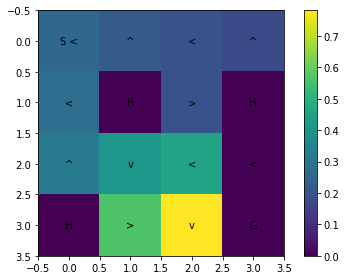

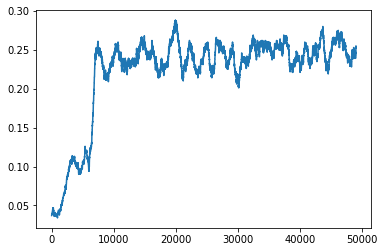

In [44]:
plotQ(q4_SARSA, 4)
plt.plot(running_avg(episodes_reward4_SARSA, 1000))

100%|██████████| 1000/1000 [00:00<00:00, 1675.10it/s]


Mean = 0.753


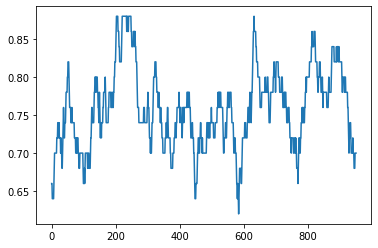

In [45]:
# Evaluation de la politique courante (sans exploration)
rewards4_SARSA, rewards_mean4_SARSA = exploit_and_plot(env4, q4_SARSA, num_episodes=1000, window_size=50)

### 2.3 FrozenLake 8x8

In [46]:
env8 = gym.make("FrozenLake8x8-v0",  is_slippery=True)
q8_SARSA, episodes_reward8_SARSA = SARSA(env8, num_episodes=50000, gamma=1, alpha=0.02, epsilon=0.2)

100%|██████████| 50000/50000 [03:54<00:00, 212.86it/s]


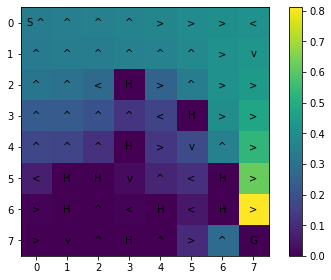

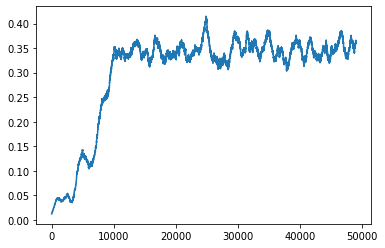

In [47]:
plotQ(q8_SARSA, 8)
plt.plot(running_avg(episodes_reward8_SARSA, 1000))

100%|██████████| 50000/50000 [01:26<00:00, 576.42it/s]


Mean = 0.85518


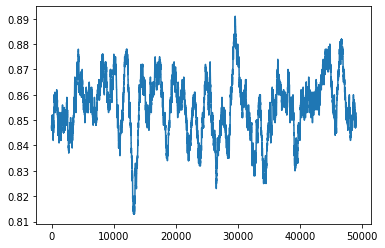

In [67]:
# Evaluation de la politique courante (sans exploration)
rewards8_SARSA, rewards_mean8_SARSA = exploit_and_plot(env8, q8_SARSA, num_episodes=50000, window_size=1000)

## <a name="sec3">3. Q-learning</a>





Implémentez l'algorithme Q-learning (en partant de SARSA, il ne devrait y avoir que quelques lignes de codes à modifier !)

In [55]:
def Q_learning(env, num_episodes, gamma=1, alpha=0.02, epsilon=0.2, verbose=False):
    
    # Initialization
    q = np.zeros((env.observation_space.n, env.action_space.n))
    episodes_reward = [] # Final reward per episode (0 or 1)
    
    # Starting the SARSA learning
    for i_episode in tqdm(range(num_episodes)):
        
        state = env.reset()
        action = eps_greedy(q, state, epsilon)
        
        done = False
        while not done:
            
            # Execute action, observe the reward and get the next state
            next_state, reward, done, _ = env.step(action)

            # Learning the Q-value
            if done: # new_state is terminal
                q[state, action] = q[state, action] + alpha * (reward - q[state, action])
                episodes_reward.append(reward)
                break
            else:
                best_action = np.random.choice(np.argwhere(q[next_state] == np.amax(q[next_state])).flatten().tolist())
                q[state, action] = q[state, action] + alpha * (reward + gamma*q[next_state, best_action] - q[state, action])
                next_action = eps_greedy(q, next_state, epsilon)
                state = next_state
                action = next_action
            
    return q, episodes_reward

In [59]:
q8_qlearn, episodes_reward8_qlearn = Q_learning(env8, num_episodes=50000, gamma=1, alpha=0.02, epsilon=0.2)

100%|██████████| 50000/50000 [05:54<00:00, 140.86it/s]


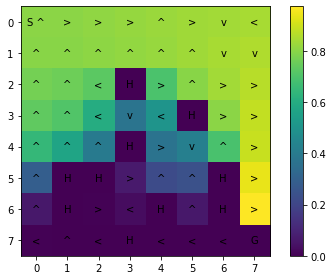

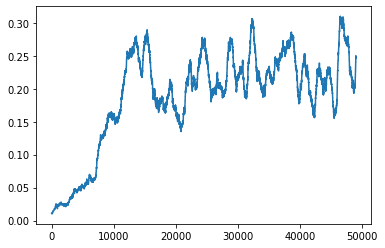

In [60]:
plotQ(q8_qlearn, 8)
plt.plot(running_avg(episodes_reward8_qlearn, 1000))

100%|██████████| 50000/50000 [01:32<00:00, 539.83it/s]


Mean = 0.80172


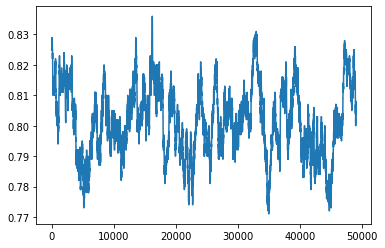

In [68]:
# Evaluation de la politique courante (sans exploration)
rewards8_qlearn, rewards_mean8_qlearn = exploit_and_plot(env8, q8_qlearn, num_episodes=50000, window_size=1000)

## <a name="sec4">4. Comparaison</a>

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

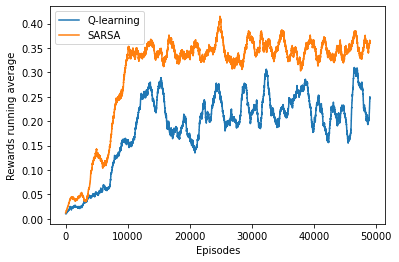

In [70]:
plt.xlabel("Episodes")
plt.ylabel("Rewards running average")
plt.plot(running_avg(episodes_reward8_qlearn, window_size=1000), label="Q-learning")
plt.plot(running_avg(episodes_reward8_SARSA, window_size=1000), label="SARSA")
plt.legend()
plt.show()

## <a name="sec5">5. Cart-pole en tabulaire</a>

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [71]:
env_CP = gym.make("CartPole-v1")
print("Environnement avec", env_CP.action_space.n, "actions")
print("L'espace des états est lui codé avec une class", env_CP.observation_space,
      " qui représente un espace continu")
print("Les bornes inférieures des intervalles sont:", env_CP.observation_space.low)
print("Les bornes supérieures des intervalles sont:", env_CP.observation_space.high)
env_CP.reset()
nbIt=0
done=False
while not done:
    observation, reward, done, info = env_CP.step(np.random.randint(2))
    nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env_CP.close()

Environnement avec 2 actions
L'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
Les bornes inférieures des intervalles sont: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Les bornes supérieures des intervalles sont: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 26 itérations


In [72]:
nval = 5 # nombre de valeurs discrètes qu’une variable peut prendre ??
N = nval**4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
print("Le nombre d'états sera ici de", N)

Le nombre d'états sera ici de 625


In [73]:
def discretise(x, mini, maxi):
    """
    Discretise x. Renvoie un entier entre 0 et nval-1
        x: une des variables parmi position, velocite, angle, position haut poutre
        mini: borne inf
        maxi: borne sup
    """
    if x<mini: x=mini
    if x>maxi: x=maxi
    return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
    pos = discretise(observation[0],mini=-1,maxi=1)
    vel = discretise(observation[1],mini=-1,maxi=1)
    angle = discretise(observation[2],mini=-1,maxi=1)
    pos2 = discretise(observation[3],mini=-1,maxi=1)
    return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval

Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utiliser les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement ! 
Avec comme paramètres $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive à atteindre un score autour de 90 pas de temps.

In [110]:
def SARSA_CP(env, num_episodes, gamma=0.9, alpha=0.2, epsilon=0.1, num_states=N, num_actions=2, verbose=False):
    
    # Initialization
    q = np.zeros((num_states, num_actions))
    episodes_reward = []
    
    # Starting the SARSA learning
    for i_episode in tqdm(range(num_episodes)):
        
        total_reward =0

        state = env.reset()
        action = eps_greedy(q, encode(state), epsilon, num_actions)
        
        done = False
        while not done:
            
            i_state = encode(state)

            # Execute action, observe the reward and get the next state
            next_state, reward, done, _ = env.step(action)
            i_next_state = encode(next_state)
            total_reward += reward
            
            # Learning the Q-value
            if done: # new_state is terminal
                q[i_state, action] = q[i_state, action] + alpha * (reward - q[i_state, action])
                episodes_reward.append(total_reward)
                break
            else:
                next_action = eps_greedy(q, i_next_state, epsilon, num_actions)
                q[i_state, action] = q[i_state, action] + alpha * (reward + gamma*q[i_next_state, next_action] - q[i_state, action])
                action = next_action
                
            state = next_state

    return q, episodes_reward

In [111]:
def exploitation_CP(env, q, num_episodes):
    
    # Initialization
    episodes_reward = []
    
    # For every episode...
    for i_episode in tqdm(range(num_episodes)):

        total_reward = 0

        state = env.reset()
        action = np.argmax(q[encode(state)])
 
        done = False
        while not done:
            state, reward, done, _ = env.step(action)
            action = np.argmax(q[encode(state)])
            total_reward += reward

        episodes_reward.append(total_reward)
        
    return episodes_reward, np.mean(episodes_reward)

$\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$

100%|██████████| 10000/10000 [01:48<00:00, 92.16it/s]


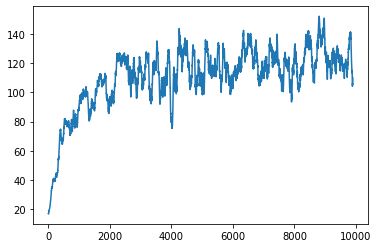

In [112]:
q_CP_SARSA, episodes_reward_CP_SARSA = SARSA_CP(env_CP, num_episodes=10000, verbose=False)
plt.plot(running_avg(episodes_reward_CP_SARSA, 100))

100%|██████████| 1000/1000 [00:06<00:00, 163.42it/s]


118.539

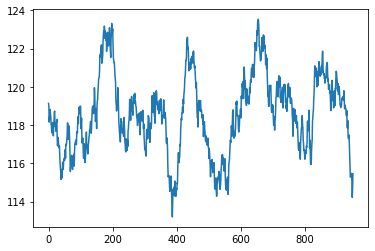

In [116]:
episodes_reward_CP_SARSA_exploit, mean_CP_SARSA_exploit = exploitation_CP(env_CP, q_CP_SARSA, num_episodes=1000)
plt.plot(running_avg(episodes_reward_CP_SARSA_exploit, window_size=50))
mean_CP_SARSA_exploit

$\epsilon=0.15$, $\alpha=0.05$ et $\gamma=0.7$

100%|██████████| 10000/10000 [01:24<00:00, 118.70it/s]


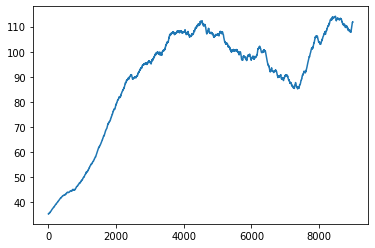

In [106]:
q_CP_SARSA, episodes_reward_CP_SARSA = SARSA_CP(env_CP, num_episodes=10000, gamma=0.7, alpha=0.05, epsilon=0.15, verbose=False)
plt.plot(running_avg(episodes_reward_CP_SARSA, 1000))

100%|██████████| 1000/1000 [00:06<00:00, 146.83it/s]


139.365

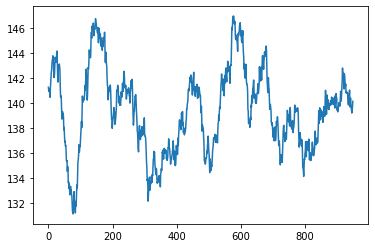

In [107]:
episodes_reward_CP_SARSA_exploit, mean_CP_SARSA_exploit = exploitation_CP(env_CP, q_CP_SARSA, num_episodes=1000)
plt.plot(running_avg(episodes_reward_CP_SARSA_exploit, window_size=50))
mean_CP_SARSA_exploit